In [1]:
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
import numpy as np
from sklearn.model_selection import train_test_split
import os, glob
import matplotlib.pyplot as plt
import cv2
from keras.applications.mobilenet_v2 import MobileNetV2

from DataGenerator import DataGenerator

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = False
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [ ]:
base_path = '/mnt2/iris_processed/'

json_list = glob.glob(os.path.join(base_path, '*/data/*.json'))

json_list[:10]

In [2]:
# np.savez_compressed(os.path.join(base_path, 'json_list.npz'), data=json_list)

base_path = '/mnt2/iris_processed/'
json_list = np.load(os.path.join(base_path, 'json_list.npz'))['data']

In [3]:
print(len(json_list))

5200182


In [4]:
json_list_train, json_list_val = train_test_split(json_list, test_size=0.1, random_state=2020)

print(len(json_list_train), len(json_list_val))

4680163 520019


In [5]:
BATCH_SIZE = 32
IMG_SIZE = 96
N_CHANNEL = 3

train_gen = DataGenerator(
    phase='train',
    file_list=json_list_train,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channel=N_CHANNEL
)

val_gen = DataGenerator(
    phase='val',
    file_list=json_list_val,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channel=N_CHANNEL
)

print('Done!')

Done!


(32, 96, 96, 3)
(32, 38)
[[52.418415 48.678196]
 [52.014256 51.733654]
 [50.38954  54.227486]
 [48.021088 56.089085]
 [45.211903 57.066204]
 [42.20848  57.00544 ]
 [39.282375 56.252693]
 [37.05456  54.510967]
 [35.325016 52.032875]
 [34.489014 49.13831 ]
 [34.60058  46.20311 ]
 [35.58244  43.317574]
 [37.725456 41.164543]
 [40.20943  39.661163]
 [43.204044 39.197315]
 [46.141663 39.589413]
 [48.87619  40.904377]
 [50.9628   43.042053]
 [52.216766 45.749916]]


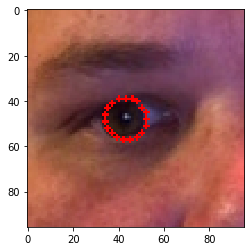

In [6]:
test_data = val_gen.__getitem__(0)

print(test_data[0].shape)
print(test_data[1].shape)

test_img = test_data[0][0].squeeze()
test_contour = test_data[1][0].squeeze().reshape((-1, 2))

print(test_contour)

for p in test_contour:
    cv2.circle(test_img, center=tuple(p.astype(int)), radius=1, color=1, thickness=-1, lineType=cv2.LINE_AA)

plt.imshow(test_img)

In [7]:
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense
from keras.models import Model

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNEL))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(1280, activation='relu')(x)

x = BatchNormalization()(x)
output = Dense(38, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='mse', optimizer='adam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
____________________

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from datetime import datetime

os.makedirs('models', exist_ok=True)
start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05),
        ModelCheckpoint('models/%s-{epoch:02d}-{val_loss:.2f}.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1),
        TensorBoard(log_dir='logs/%s' % (start_time))
    ],
    use_multiprocessing=True,
    workers=5,
    max_queue_size=5
)

Epoch 1/50
146255/146255 [==============================] - 12606s 86ms/step - loss: 27.1984 - val_loss: 22.3336

Epoch 00001: val_loss improved from inf to 22.33364, saving model to models/2020-08-13_09-15-19-01-22.33.h5
Epoch 1/50
Epoch 2/50
146255/146255 [==============================] - 12308s 84ms/step - loss: 26.8413 - val_loss: 19.7651

Epoch 00002: val_loss improved from 22.33364 to 19.76510, saving model to models/2020-08-13_09-15-19-02-19.77.h5
Epoch 3/50
146255/146255 [==============================] - 12947s 89ms/step - loss: 26.4309 - val_loss: 22.3339

Epoch 00002: val_loss improved from 22.33364 to 19.76510, saving model to models/2020-08-13_09-15-19-02-19.77.h5

Epoch 00003: val_loss did not improve from 19.76510
Epoch 4/50
146255/146255 [==============================] - 13423s 92ms/step - loss: 26.2415 - val_loss: 21.3867

Epoch 00004: val_loss did not improve from 19.76510
Epoch 5/50
Epoch 4/50
146255/146255 [==============================] - 12522s 86ms/step - loss

In [6]:
from keras.models import load_model

best_model = load_model('models/2020-08-13_09-15-19-08-19.74.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


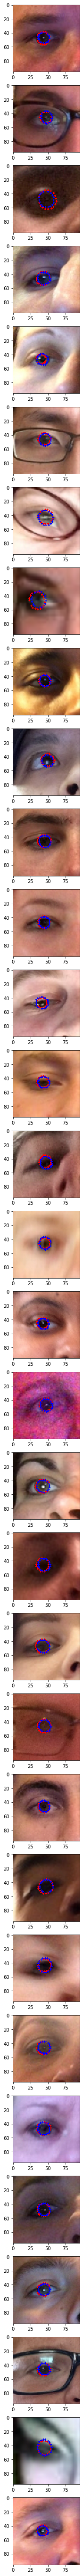

In [23]:
test_data = val_gen.__getitem__(0)

fig, axes = plt.subplots(BATCH_SIZE, 1, figsize=(10, 100))

for i, (img, contour) in enumerate(zip(test_data[0], test_data[1])):
    # ground truth
    gt_contour = contour.reshape((-1, 2))
    
    for p in gt_contour:
        cv2.circle(img, center=tuple(p.astype(int)), radius=1, color=(1, 0, 0), thickness=-1, lineType=cv2.LINE_AA)

    # prediction
    pred_contour = best_model.predict(np.expand_dims(img, axis=0)).reshape((-1, 2))

    for p in pred_contour:
        cv2.circle(img, center=tuple(p.astype(int)), radius=1, color=(0, 0, 1), thickness=-1, lineType=cv2.LINE_AA)

    axes[i].imshow(img)